# Starbucks Capstone Project  
I was intrigued by the promotional offers that companies like Starbucks give to its customers. I was interested to know if the offers given by Starbucks really made any difference in thier sale, or how do the offers affect customer behavior but most importantly i wanted to know how much any customer spend at Starbucks. So, I decided to explore myself. 

#### Problem Statement:
In this project i will be trying to predict the amount of product a customer will purchase based on various parameters, including the offers given to the customer. This makes it a supervised learning regression problem.

#### Metrics:  
I will be using **Root mean squared error (RMSE)** as the metric to evaluate my model performance. 

##### **Why did I choose RMSE as the metric ?**   
Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.  

**Some advantages in using RMSE:**  

1) It is simple and intuitive to understand for a layman as it has the same units as that of target value. It simply means how far our predictions are from the actual values.  

2) It is easy and not computationally expensive to calculate.  

3) Since we are squaring the values, hence the positive and negative error values do not cancel out.    

4) Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors compared to small errors.  

5) RMSE is the default metric of many models because loss function defined in terms of RMSE is smoothly differentiable and makes it easier to perform mathematical operations.  

I looked at some other options like Mean Absolute Error (MAE), Mean Bias Error (MBE), Mean Squared Error(MSE), R-Squared; but found RMSE better suited to my purpose because:  

1) **Mean Absolute Error (MAE):** MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. Which simply means MAE gives equal weight to large errors as well as small errors. Hence, RMSE is more useful when large errors are particularly undesirable, which was my case. Also, MAE takes the absolute value, which is undesirable in many mathematical calculations.    

2) **Mean Bias Error (MBE):** If the absolute value is not taken in MAE (the signs of the errors are not removed), the average error becomes the Mean Bias Error (MBE) and is usually intended to measure average model bias. MBE can convey useful information, but should be interpreted cautiously because positive and negative errors will cancel out. Which for our purpose is not desired.   

3) **Mean Squared Error (MSE):** RMSE is just the square root of the MSE. Thus, tt do not have the same units as that of target value, but the square of them. Therefore, i did not used it.  

4) **R-Square:** R-squared says nothing about prediction error. We cannot use R-squared to determine whether the coefficient estimates and predictions are biased, which is why one must assess the residual plots. R-squared does not necessarily indicate if a regression model provides an adequate fit to your data. A good model can have a low R2 value. On the other hand, a biased model can have a high R2 value. Therefore, i did not use R-square as metric


**Let us see the full process below:**

For this project I am going to follow **CRISP-DM** process, that has the following stages:  
1) Business Understanding  
2) Data Understanding  
3) Prepare Data  
4) Data Modeling  
5) Evaluate the Results  
6) Deploy  

### 1) Business Understanding

Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Also, not all users receive the same offer, and that is the challenge to solve.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. Informational offers also have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, it is assumed that the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Finally, it should be kept in mind that someone using the app might make a purchase through the app without having received an offer or seen an offer.

#### Example:

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.



### 2) Data Understanding
The data set that I will be using contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. 
This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


Let us do some **Exploratory Data Analysis (EDA)** for understanding the data better.

In [1]:
# importing all the libraries 
import pandas as pd
import numpy as np
import json
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
% matplotlib inline


In [2]:
# reading the data 
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
# null values in the profile data
profile.isnull().sum() 

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [7]:
# Number of male, female and others
print(profile['gender'].value_counts())

M    8484
F    6129
O     212
Name: gender, dtype: int64


In [8]:
# Percentage of male, female and others
print(profile['gender'].value_counts()*100/profile.shape[0])

# Sum of percentages
sum(profile['gender'].value_counts()*100/profile.shape[0])

M    49.905882
F    36.052941
O     1.247059
Name: gender, dtype: float64


87.20588235294119

We can see that the above percentages do not add upto 100. Which indicates that there are some missing values in gender column

**Some exploration about age**

In [9]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

<Container object of 85 artists>

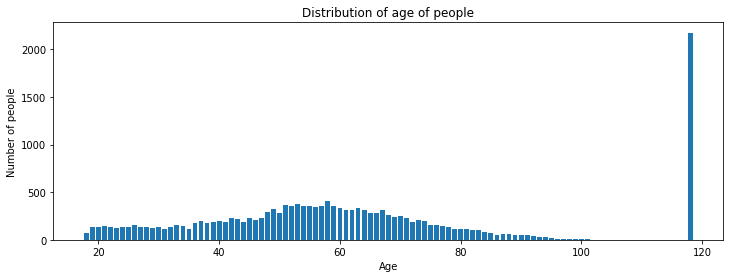

In [10]:
age_df = profile.groupby(['age'])['id'].count()
plt.figure(figsize=(12,4))
plt.xlabel('Age')
plt.ylabel('Number of people')
plt.title('Distribution of age of people')

plt.bar(age_df.index, age_df)

Its is quite strange to find so many people with 118 age. After some research i found it to be a code for missing values. This indicates some unclean data. We will see it in perpare data stage.

**Some exploration about income**

In [11]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

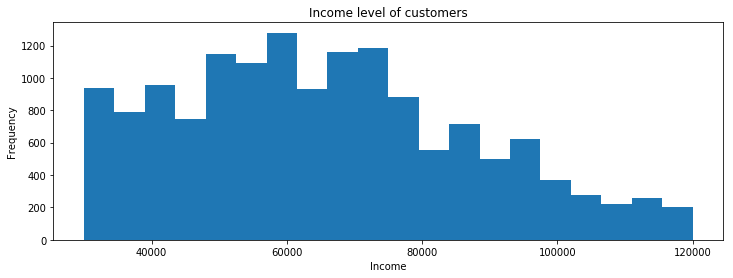

In [12]:
plt.figure(figsize=(12,4))
plt.xlabel('Income')
plt.title('Income level of customers')
profile['income'].plot(kind="hist", bins=20)

This shows that people from all income groups drinks from starbucks

**Some exploration about when the people became a member**

In [13]:
profile['became_member_on']=pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')

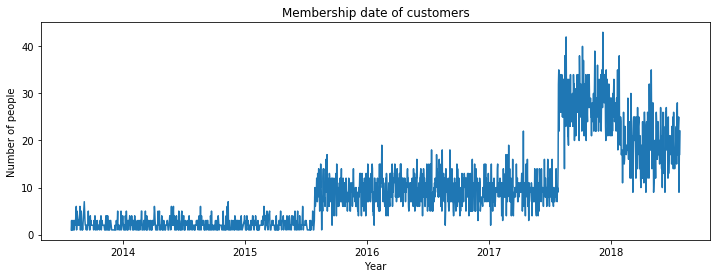

In [14]:
member_on_df = profile.groupby(['became_member_on'])['id'].count()
plt.figure(figsize=(12,4))
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Membership date of customers')

plt.plot(member_on_df)

We can see a substantial increase in the members in 2017 from the above graph

**Let us explore transcript data now**

In [15]:
event_df = transcript['event'].value_counts()
event_df = pd.DataFrame(list(zip(event_df.index.values, event_df)),
                            columns=['event', 'count'])
event_df

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


In [16]:
total_transactions = event_df['count'].sum()

percentage_transactions = 100 * event_df.iloc[0]['count'] / total_transactions
percentage_offers = 100 * event_df.iloc[1:]['count'].sum() / total_transactions

print("Percentage of customer transaction events: %.1f %%" % (percentage_transactions))
print("Percentage of customer offer events: %.1f %%" % (percentage_offers))

Percentage of customer transaction events: 45.3 %
Percentage of customer offer events: 54.7 %


### 3) Prepare Data  
Let us now prepare our data for modeling stage. We will be cleaning and preprocessing the data before it is fed into our model. Our task is to combine transaction, demographic and offer data to predict which customer will make a purchase.

First we look at **portfolio** data. For it:
- We make separate columns for each channel (web, email, mobile, social). The column has value 1 if the offer runs on that channel, otherwise it is 0.

In [17]:
# Checking for any null
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [18]:
def portfolio_cleaning(portfolio):
    '''
    Function to clean portfolio dataframe
    
    INPUT:
    portfolio - uncleaned portfolio dataframe
    
    OUTPUT:
    portfolio_cleaned_df - cleaned portfolio dataframe
    
    '''
   
    # apply one hot encoding to channels column
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # drop the channels and offer_type column
    portfolio.drop(['channels'], axis=1, inplace=True)
     
    return portfolio

In [19]:
portfolio_cleaned_df = portfolio_cleaning(portfolio)
portfolio_cleaned_df

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


Now, cleaning the **profile** data. For it:
- As noted earlier 118 is the code for missing values in age colum, so i delete the rows with missing data.
- I have also created a new column of "memberdays" i.e. the number of days since the user is a member of starbucks. This will be more intutive than the "became_member_on" colum

In [20]:
# Checking null values 
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

We observe that both gender and income column has 2175 null values. Let us see how may rows have 118 (missing value code for age) as value in age column 

In [21]:
# Finding missing values in age column
missing_age = profile['age'].apply(lambda x: np.nan if x == 118 else x)
missing_age.isna().sum()

2175

So, we get the same number 2175. 

In [22]:
profile.isna().head(20)

,age,became_member_on,gender,id,income
0,False,False,True,False,True
1,False,False,False,False,False
2,False,False,True,False,True
3,False,False,False,False,False
4,False,False,True,False,True
5,False,False,False,False,False
6,False,False,True,False,True
7,False,False,True,False,True
8,False,False,False,False,False
9,False,False,True,False,True


Taking a quick look at the data it seems that the rows with missing age, income and gender coincides. We will confirm it further below. In the function below for cleaning profile data i have deleted the rows with missing age value, we will see how it affects gender and income missing value rows.

In [23]:
def profile_cleaning(profile):
    '''
    Function to clean profile dataframe
    
    INPUT:
    profile - uncleaned profile dataframe
    
    OUTPUT:
    profile - cleaned profile dataframe
    
    '''
    # Replacing 118 code with NaN
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # Removing all the missing values 
    profile.dropna(subset=['age'], inplace=True)
    
    # Creating a new column from "became_member_on" indicating the number of days since the user is a member of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    return profile

In [24]:
profile_cleaned_df = profile_cleaning(profile)
profile_cleaned_df.head()

,age,became_member_on,gender,id,income,memberdays
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,799
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,866
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,514
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,590
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,680


Let us see if removing rows with missing age had any effect on rows with missing gender and income values (that we observed earlier). 

In [25]:
# Checking null values 
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
memberdays          0
dtype: int64

From above we can see that the rows with missing values in gender and income columns also got deleted when we removed rows with missing age. We can conclude that those rows were suspicious of some incorrect data, hence we did the right thing deleting them altogether.

Now finally cleaning the **transcript** data. 

In [26]:
# Checking for any missing values in transcript data
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [27]:
# Finding unique types of values in "value" column (stored as a dict)
value_types = set()
for i in transcript.value:
    value_types.update(set(i.keys()))
value_types

{'amount', 'offer id', 'offer_id', 'reward'}

From above we can see that "value" column has {'amount', 'offer id', 'offer_id', 'reward'} types of details. We can see that 'offer id' and 'offer_id' are represented seperately in the data. But we know they are one and the same thing. This will require some cleaning.

In [28]:
def clean_offer_id(x):
    """
    Helper function to clean transcript data. 
    It helps in making "offer_id" column by clubbing 'offer id' and 'offer_id' values as observed above.
    
    INPUT:
    x - dictionary from transcript['value'] column data
    
    OUTPUT:
    value - value of the offer_id or offer id
    """
    for i in ["offer_id", "offer id"]:
        if i in x:
            value = x[i]
            break
    else:
        value = np.nan
    
    return value

def clean_transcript(transcript):
    '''
    Function to clean transcript dataframe
    
    INPUT:
    transcript - uncleaned transcript dataframe
    
    OUTPUT:
    transcript - cleaned transcript dataframe
    
    '''
    # Making two separate columns "amount" and "reward" from "value" column. 
    # These column will contain their respective amounts if they have one otherwise NaN
    for i in ["amount", "reward"]:
        transcript[i] = transcript['value'].apply(lambda x: x[i] if i in x else np.nan)
    
    # Making "offer_id" column clubbing 'offer id' and 'offer_id' values as observed above from "value" column.
    # This column will contain the respective offer value if it has one otherwise NaN
    transcript["offer_id"] = transcript['value'].apply(clean_offer_id)
    
    # drop the "value" column
    transcript.drop(['value'], axis=1, inplace=True)
    
    return transcript 

In [29]:
transcript_cleaned_df = clean_transcript(transcript)
transcript_cleaned_df.head()

,event,person,time,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


Let us now check for any duplicate values in any of the 3 cleaned data sets.

In [30]:
transcript_cleaned_df.duplicated().sum(), portfolio_cleaned_df.duplicated().sum(), profile_cleaned_df.duplicated().sum()

(397, 0, 0)

So we have some duplicate values in transcript_cleaned_df. Let us remove them

In [31]:
# Drop duplicates from transcript_cleaned_df
transcript_cleaned_df.drop_duplicates(inplace=True)
transcript_cleaned_df.reset_index(drop=True, inplace=True)

After having cleaned all the data sets, it is now time to join the three and make a consolidated data frame.

In [32]:
# Merging the data frames
data_temp = transcript_cleaned_df.merge(profile_cleaned_df, how="inner", left_on="person", right_on="id")
data_temp.drop("id", inplace=True, axis=1)
data_merged = data_temp.merge(portfolio_cleaned_df, how="left", left_on="offer_id", right_on="id")
data_merged.drop("id", inplace=True, axis=1)
data_merged = pd.get_dummies(data_merged , columns=['event'], prefix='', prefix_sep='')

In [33]:
data_merged.head()

,person,time,amount,reward_x,offer_id,age,became_member_on,gender,income,memberdays,...,offer_type,reward_y,web,email,mobile,social,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,F,100000.0,866,...,bogo,5.0,1.0,1.0,1.0,0.0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,F,100000.0,866,...,bogo,5.0,1.0,1.0,1.0,0.0,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN,75.0,2017-05-09,F,100000.0,866,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,F,100000.0,866,...,bogo,5.0,1.0,1.0,1.0,0.0,1,0,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN,75.0,2017-05-09,F,100000.0,866,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1


In [34]:
data_merged.columns

Index(['person', 'time', 'amount', 'reward_x', 'offer_id', 'age',
       'became_member_on', 'gender', 'income', 'memberdays', 'difficulty',
       'duration', 'offer_type', 'reward_y', 'web', 'email', 'mobile',
       'social', 'offer completed', 'offer received', 'offer viewed',
       'transaction'],
      dtype='object')

In [35]:
# Aggregating the data frame
data_final = data_merged.groupby(['person' ]).agg(
    {    'age':'last',
         'became_member_on':'last',
         'memberdays':'last',            
         'gender':'last',
         'income':'last',
         'offer completed':'sum',   
         'offer received':'sum', 
         'offer viewed':'sum',
         'difficulty':'sum',
         'reward_x':'sum',
         'reward_y':'sum',
         'web':'sum',
         'email':'sum',
         'mobile':'sum',
         'social':'sum',
         'transaction':'sum',
         'amount':'sum'
    }
).reset_index()

In [36]:
data_final.head()

,person,age,became_member_on,memberdays,gender,income,offer completed,offer received,offer viewed,difficulty,reward_x,reward_y,web,email,mobile,social,transaction,amount
0,0009655768c64bdeb2e877511632db8f,33.0,2017-04-21,884,M,72000.0,3,5,4,65.0,9.0,25.0,10.0,12.0,12.0,8.0,8,127.60
1,0011e0d4e6b944f998e987f904e8c1e5,40.0,2018-01-09,621,O,57000.0,3,5,5,96.0,13.0,39.0,11.0,13.0,10.0,5.0,5,79.46
2,0020c2b971eb4e9188eac86d93036a77,59.0,2016-03-04,1297,F,90000.0,3,5,3,90.0,14.0,50.0,8.0,11.0,11.0,11.0,8,196.86
3,0020ccbbb6d84e358d3414a3ff76cffd,24.0,2016-11-11,1045,F,60000.0,3,4,4,51.0,13.0,39.0,9.0,11.0,11.0,8.0,12,154.05
4,003d66b6608740288d6cc97a6903f4f0,26.0,2017-06-21,823,F,73000.0,3,5,4,100.0,9.0,22.0,10.0,12.0,10.0,8.0,18,48.34


### 4) Data Modeling
In this stage we will train our model to predict the amount of product a customer will purchase.

First let us create two new features of 'year_joined' and 'month_joined' from 'became_member_on' column. Then we will drop 'became_member_on' column.
Please note that previously we have already created the feature 'memberdays', as it was more intuitive.

In [37]:
data_final['year_joined'] = data_final['became_member_on'].dt.year
data_final['month_joined'] = data_final['became_member_on'].dt.month
data_final.drop(['became_member_on'], axis=1, inplace=True)

We should now standardise 'income' and 'memberdays' features using MinMaxScaler() as they have a wide range as compared to other features, especially 'income'.

Now we one hot encode the categorical column of gender.

In [38]:
# One hot encoding gender column
data_final = pd.get_dummies(data_final , columns=['gender'], prefix='', prefix_sep='')

In [39]:
data_final.head()

,person,age,memberdays,income,offer completed,offer received,offer viewed,difficulty,reward_x,reward_y,...,email,mobile,social,transaction,amount,year_joined,month_joined,F,M,O
0,0009655768c64bdeb2e877511632db8f,33.0,884,72000.0,3,5,4,65.0,9.0,25.0,...,12.0,12.0,8.0,8,127.60,2017,4,0,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,40.0,621,57000.0,3,5,5,96.0,13.0,39.0,...,13.0,10.0,5.0,5,79.46,2018,1,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,59.0,1297,90000.0,3,5,3,90.0,14.0,50.0,...,11.0,11.0,11.0,8,196.86,2016,3,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,24.0,1045,60000.0,3,4,4,51.0,13.0,39.0,...,11.0,11.0,8.0,12,154.05,2016,11,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,26.0,823,73000.0,3,5,4,100.0,9.0,22.0,...,12.0,10.0,8.0,18,48.34,2017,6,1,0,0


Let us now split the data into features and target label and then into training and testing data sets. 

In [40]:
def train_test_data(data_final):
    '''
    Function to make training and testing data
    
    INPUT:
    data_df - data set having features and target variables
    
    OUTPUT:
    x_train - training feature variables
    x_test - testing feature variables
    y_train - training target variable
    y_test - testing target variable
    
    '''
    # Setting target variable to 'amount'
    y = data_final['amount']
    
    # Making feature data set by removing target variable 'amount' from it
    # We also remove 'person' column as it gives no information to model
    x = data_final.drop(['amount', 'person'], axis=1)
    
    # Making training and testing data sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=37)
    
    return x_train, x_test, y_train, y_test

In [41]:
# Making training and testing data sets
x_train, x_test, y_train, y_test = train_test_data(data_final)

**For initial baseline model let us Random Forest algorithm with default parameters and see how it performs.**

In [42]:
def model_evaluate(x_train, x_test, y_train, y_test, model):
    '''
    Function to take in the training and testing data and evaluate model performance
    
    INPUT:
    model - model instance to use
    x_train - training feature variables
    x_test - testing feature variables
    y_train - training target variable
    y_test - testing target variable
    Output:
    train_rmse - Root Mean Squared Error on Training Data
    test_rmse - Root Mean Squared Error on Testing Data
    
    '''
       
    # Fitting model instance on training data
    model.fit(x_train, y_train)
    
    # Model predictions on train data 
    y_train_predict = predict = model.predict(x_train)

    # Model predictions on test data 
    y_test_predict = predict = model.predict(x_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predict))

    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
    
    return train_rmse, test_rmse

In [43]:
model = RandomForestRegressor()
train_rmse, test_rmse = model_evaluate(x_train, x_test, y_train, y_test, model)

In [44]:
print("Baseline Random Forest model performance:- Train RMSE error: {}, Test RMSE error: {}".format(train_rmse, test_rmse))

Baseline Random Forest model performance:- Train RMSE error: 43.40822633356865, Test RMSE error: 100.12625339540412


**Now we have a baseline benchmark to improve our model upon. We will now be making a pipeline with MinMaxScaler() and use XGBoost Regressor as our model. Then we will use GridSearchCV to tune the hyper parameters of our model to give best results.**

In [45]:
pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', xgb.XGBRegressor())
])

In [46]:
parameters = {
    'model__n_estimators':[50, 75, 100, 125],
    'model__max_depth':[3, 4, 5],
    'model__learning_rate':[0.03, 0.06, 0.1]
             }

cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs = -1, verbose=2)

In [47]:
train_rmse, test_rmse = model_evaluate(x_train, x_test, y_train, y_test, cv)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=50 
[15:55:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=50, total=   0.4s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=50 
[15:55:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=50, total=   0.4s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=50 
[15:55:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=50, total=   0.4s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=75 
[15:55:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=75, total=   0.6s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=75 
[15:55:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=75, total=   0.6s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=75 
[15:55:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=75, total=   0.6s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=100 
[15:55:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=100, total=   0.7s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=100 
[15:55:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=100, total=   0.7s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=100 
[15:55:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=100, total=   0.7s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=125 
[15:55:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=125, total=   0.9s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=125 
[15:55:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=125, total=   0.9s
[CV] model__learning_rate=0.03, model__max_depth=3, model__n_estimators=125 
[15:55:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=3, model__n_estimators=125, total=   0.9s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=50 
[15:55:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=50, total=   0.5s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=50 
[15:55:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=50, total=   0.5s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=50 
[15:55:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=50, total=   0.5s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=75 
[15:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=75, total=   0.7s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=75 
[15:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=75, total=   0.7s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=75 
[15:55:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=75, total=   0.7s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=100 
[15:55:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=100, total=   0.9s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=100 
[15:55:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=100, total=   0.9s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=100 
[15:55:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=100, total=   0.9s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=125 
[15:55:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=125, total=   1.2s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=125 
[15:55:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=125, total=   1.2s
[CV] model__learning_rate=0.03, model__max_depth=4, model__n_estimators=125 
[15:55:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=4, model__n_estimators=125, total=   1.2s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=50 
[15:55:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=50, total=   0.6s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=50 
[15:56:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=50, total=   0.6s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=50 
[15:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=50, total=   0.6s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=75 
[15:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=75, total=   0.9s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=75 
[15:56:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=75, total=   0.9s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=75 
[15:56:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=75, total=   0.9s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=100 
[15:56:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=100, total=   1.2s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=100 
[15:56:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=100, total=   1.3s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=100 
[15:56:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=100, total=   1.2s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=125 
[15:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=125, total=   1.5s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=125 
[15:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=125, total=   1.5s
[CV] model__learning_rate=0.03, model__max_depth=5, model__n_estimators=125 
[15:56:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.03, model__max_depth=5, model__n_estimators=125, total=   1.5s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=50 
[15:56:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=50, total=   0.4s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=50 
[15:56:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=50, total=   0.4s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=50 
[15:56:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=50, total=   0.4s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=75 
[15:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=75, total=   0.6s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=75 
[15:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=75, total=   0.6s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=75 
[15:56:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=75, total=   0.6s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=100 
[15:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=100, total=   0.7s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=100 
[15:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=100, total=   0.7s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=100 
[15:56:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=100, total=   0.7s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=125 
[15:56:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=125, total=   0.9s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=125 
[15:56:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=125, total=   0.9s
[CV] model__learning_rate=0.06, model__max_depth=3, model__n_estimators=125 
[15:56:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=3, model__n_estimators=125, total=   0.9s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=50 
[15:56:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=50, total=   0.5s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=50 
[15:56:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=50, total=   0.5s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=50 
[15:56:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=50, total=   0.5s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=75 
[15:56:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=75, total=   0.7s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=75 
[15:56:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=75, total=   0.7s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=75 
[15:56:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=75, total=   0.7s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=100 
[15:56:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=100, total=   0.9s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=100 
[15:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=100, total=   0.9s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=100 
[15:56:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=100, total=   0.9s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=125 
[15:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=125, total=   1.1s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=125 
[15:56:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=125, total=   1.2s
[CV] model__learning_rate=0.06, model__max_depth=4, model__n_estimators=125 
[15:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=4, model__n_estimators=125, total=   1.2s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=50 
[15:56:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=50, total=   0.6s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=50 
[15:56:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=50, total=   0.6s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=50 
[15:56:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=50, total=   0.6s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=75 
[15:56:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=75, total=   0.9s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=75 
[15:56:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=75, total=   0.9s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=75 
[15:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=75, total=   0.9s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=100 
[15:56:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=100, total=   1.2s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=100 
[15:56:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=100, total=   1.2s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=100 
[15:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=100, total=   1.2s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=125 
[15:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=125, total=   1.4s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=125 
[15:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=125, total=   1.4s
[CV] model__learning_rate=0.06, model__max_depth=5, model__n_estimators=125 
[15:56:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.06, model__max_depth=5, model__n_estimators=125, total=   1.4s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50 
[15:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50, total=   0.4s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50 
[15:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50, total=   0.4s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50 
[15:56:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50, total=   0.4s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=75 
[15:56:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=75, total=   0.6s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=75 
[15:56:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=75, total=   0.6s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=75 
[15:56:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=75, total=   0.6s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100 
[15:56:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100, total=   0.7s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100 
[15:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100, total=   0.7s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100 
[15:56:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100, total=   0.7s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=125 
[15:56:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=125, total=   0.9s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=125 
[15:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=125, total=   0.9s
[CV] model__learning_rate=0.1, model__max_depth=3, model__n_estimators=125 
[15:56:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=3, model__n_estimators=125, total=   0.9s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50 
[15:56:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50, total=   0.5s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50 
[15:56:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50, total=   0.5s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50 
[15:56:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50, total=   0.5s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=75 
[15:56:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=75, total=   0.7s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=75 
[15:56:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=75, total=   0.7s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=75 
[15:56:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=75, total=   0.7s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100 
[15:56:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100, total=   0.9s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100 
[15:56:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100, total=   0.9s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100 
[15:56:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100, total=   0.9s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=125 
[15:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=125, total=   1.1s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=125 
[15:57:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=125, total=   1.1s
[CV] model__learning_rate=0.1, model__max_depth=4, model__n_estimators=125 
[15:57:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=4, model__n_estimators=125, total=   1.1s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=50 
[15:57:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=50, total=   0.6s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=50 
[15:57:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=50, total=   0.6s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=50 
[15:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=50, total=   0.6s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=75 
[15:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=75, total=   0.9s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=75 
[15:57:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=75, total=   0.9s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=75 
[15:57:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=75, total=   0.9s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100 
[15:57:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, total=   1.1s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100 
[15:57:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, total=   1.2s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100 
[15:57:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, total=   1.1s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=125 
[15:57:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=125, total=   1.4s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=125 
[15:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=125, total=   1.4s
[CV] model__learning_rate=0.1, model__max_depth=5, model__n_estimators=125 
[15:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  model__learning_rate=0.1, model__max_depth=5, model__n_estimators=125, total=   1.4s
[15:57:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.6min finished
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [48]:
print("Tuned XGBoost model performance:- Train RMSE error: {}, Test RMSE error: {}".format(train_rmse, test_rmse))

Tuned XGBoost model performance:- Train RMSE error: 86.93099660022715, Test RMSE error: 84.0456223669343


### Discussion about the final predictor (model):

1. I have made a pipeline of MinMaxScaler() and XGBoost Regressor(). I have fitted this pipeline on the training data and the used this pipeline to make final predictions on the testing data as well as training data. Finally, i calculated the RMSE on my predictions. Testing error got decreased from our baseline model testing error.


2. Making a pipeline makes our model really robust and easy to use. It has the following advantages:  
i) We can fit and predict on the pipeline. So, the Scaling and final model predictions happen in one step only, instead of first scaling the data and then using model to make predictions.  
ii) Use of MinMaxScaler() for standardising our data through a pipeline fits on our train data and transforms it. But it only transforms (and not fits again) the test data when pipeline is used for predicting. So, on one hand we don't have to call fit and transform on train data and onlt transform on the test data seperately (which saves effort); and on the other hand, this does not allow information from testing data creeping into the training data when we are using GridSearchCV() to find the best parameters for our model. It makes our model robust to such information leakage errors.  


3. I have used MinMaxScaler() to standardise my data in (0,1) range, so that all the features have the same scale of the data and hence do not affect our model adversely. Having features data present in different scale of values can severely decrease model performance. Hence, the model react to small changes in the dataset quite well.


4. Estimator in my pipeline is XGBoost Regressor() which is an implementation of gradient boosted decision trees designed for speed and performance. It has several advantages which makes it very robust. They are:    
i) Regularization: XGBoost has in-built L1 (Lasso Regression) and L2 (Ridge Regression) regularization which prevents the model from overfitting.  
ii) Handling Missing Values: XGBoost has an in-built capability to handle missing values. When XGBoost encounters a missing value at a node, it tries both the left and right hand split and learns the way leading to higher loss for each node. It then does the same when working on the testing data.  
iii) Effective Tree Pruning: A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm. XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.  
iv) Parallel Processing: XGBoost utilizes the power of parallel processing and that is why it is much faster than GBM. It uses multiple CPU cores to execute the model.    


5. I have used GridSearchCV() to find the best parameters for my model. It uses the default **3-fold cross validation** for its task. This makes my pipeline easily adjustable to any change in the data, as then in this stage the model will get optimised for that data only. This combined with use of pipeline makes the whole process robust.     


6. The robustness of the model can be evaluated by observing that the testing RMSE got reduced compared to our baseline results.  

#### Parameters that were fine tuned:  
I fine tuned the following parameters of XGBoost Regressor() 
- **n_estimators** in the range [50, 75, 100, 125]
- **max_depth** in the range [3, 4, 5]
- **learning_rate** in the range [0.03, 0.06, 0.1]


### 5) Evaluate the Results
From the above model performance we can see that our tuned model performs better than our baseline results. It shows that our fine tuning works well.   
- Baseline Random Forest model performance:- Train RMSE error: 43.40822633356865, Test RMSE error: 100.12625339540412  
- Tuned XGBoost model performance:- Train RMSE error: 86.93099660022715, Test RMSE error: 84.0456223669343

Though train error has increased in tuned model, but test error has reduced. This indicates that our baseline model was overfitting to some extent, while our tuned model is not over fitting.

**Justification of full process and steps followed:**  
- In this project i have followed CRISP-DM process that is the process you should follow to solve any data science problem. It gives you a proper framework to solve the problem, otherwise you may get really confused about what next steps to take. 
- I made functions when required to follow DRY principle and reused those functions. My suggestion is to do that as it saves a lot of time.
- I first explored the data and on the way found some problems with the data. It was unclean with many missing values.
- I found age=118 in the data and that too a lot data with age=118. At first i was astonished, but then thinking and researching a bit i found it was the code for missing value. 
- After cleaning the data, i had to somehow combine the 3 data frames that i had. This was a bit difficult because of different ways it was stored. It required some thinking and experimentation to find the right way to do it. 
- After merging the data i aggregated the data and processed it more. I also made some features that were more intuitive. 
- After the data was ready to be fed into the model, i split it into training and testing data as per practice to solve any data science problem.
- A baseline prediction result was obtained, after which i improved upon those results by making a pipeline and using gridsearch cv to tune hyper parameters of the model. 
- Finally i got the prediction results on training and test data, which were listed above.
- In the end i wrote the blog post explianing my project, link for which you can find below.

**Reflection:**  
- I was an interesting and relevant problem. I enjoyed the full process of CRISP-DM, the whole process was followed in a step by step manner above which really helped me to proceed in the right direction.
- I found the merging and consolidating of the three data sets in the right manner quite challenging. It required a lot of experimenting and exploring before i could do that. It is rightly said that data cleaning and preprocessing forms the most important part of any data science project. 

**Improvement Scope:**  
- One aspect of the implementation that can be improved is the feature engineering part of the project. 
- If some more relevant features could be created by collecting some extra data or using some intuitive business domain knowledge, then the prediction error could have been reduced further. 
- It would also would have led to some additional interesting findings about the customers. 

### 6) Deploy
I have wriiten a blogpost to showcase this project. 
You can find my blog post for this project on the following link: 
https://medium.com/@bhathejagautam/how-much-do-you-spend-at-starbucks-b32b66979512

Also, you can find this Jupyter Notebook and data on my github profile on the link:
https://github.com/gautambhatheja/StarbucksCapstoneProject

References:

- https://xgboost.readthedocs.io/en/latest/
- https://matplotlib.org/
- https://stackoverflow.com/
- https://www.geeksforgeeks.org/
- https://scikit-learn.org/stable/index.html